In [62]:
# Perform Google Colab installs (if running in Google Colab)
import os

if "GPU" in os.environ:
    
    !pip install -r requirements.txt --quiet
    !pip install -U torch # requires torch 2.1.1+ (for efficient sdpa implementation)
    !pip install PyMuPDF # for reading PDFs with Python
    !pip install tqdm # for progress bars
    !pip install ollama sentence-transformers
    !pip install accelerate # for quantization model loading
    !pip install bitsandbytes # for quantizing models (less storage space)
    !pip install flash-attn --no-build-isolation # for faster attention mechanism = faster LLM inference
    !pip install nltk
    

## 1. Document/Text Processing and Embedding Creation

Steps:
1. Import PDF document.
2. Process text for embedding.
3. Embed text chunks with embedding model.
4. Save embeddings to file for later use.

In [63]:
# Download PDF file
import os
import requests

# Get PDF document
pdf_path = "waste.pdf"

# Download PDF if it doesn't already exist
if not os.path.exists(pdf_path):
  print("File doesn't exist, downloading...")


  # The local filename to save the downloaded file
  filename = pdf_path

  # Send a GET request to the URL
  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:
      # Open a file in binary write mode and save the content to it
      with open(filename, "wb") as file:
          file.write(response.content)
      print(f"The file has been downloaded and saved as {filename}")
  else:
      print(f"Failed to download the file. Status code: {response.status_code}")
else:
  print(f"File {pdf_path} exists.")

File waste.pdf exists.


In [64]:
# Nécessite l'installation de PyMuPDF et tqdm
# !pip install PyMuPDF tqdm

import fitz  # PyMuPDF, sous licence AGPL-3.0 (attention pour un usage commercial)
from tqdm.auto import tqdm  # Pour les barres de progression
def text_formatter(text: str) -> str:
    """
    Formate le texte extrait pour le rendre adapté au RAG sur le recyclage.
    """
    # Remplace les sauts de ligne par des espaces et supprime les espaces inutiles
    cleaned_text = text.replace("\n", " ").strip()
    
    # Ajoute des ajustements spécifiques au domaine (optionnel) :
    # - Préserve les tirets pour les termes techniques (ex. "recyclage-basse-qualité")
    cleaned_text = cleaned_text.replace(" - ", "-")
    # - Supprime les espaces multiples pour une meilleure lisibilité
    cleaned_text = " ".join(cleaned_text.split())
    
    return cleaned_text

def open_and_read_pdf(pdf_path: str) -> list[dict]:
    """
    Ouvre un fichier PDF, lit son contenu texte page par page, et collecte des statistiques.

    Parameters:
        pdf_path (str): Chemin vers le fichier PDF.

    Returns:
        list[dict]: Liste de dictionnaires avec numéro de page, statistiques et texte extrait.
    """
    doc = fitz.open(pdf_path)  # Ouvre le document PDF
    pages_and_texts = []
    
    # Itère sur les pages avec une barre de progression
    for page_number, page in tqdm(enumerate(doc), total=len(doc)):
        text = page.get_text()  # Extrait le texte brut (UTF-8)
        text = text_formatter(text)  # Applique le formatage
        
        # Ajoute les métadonnées pour chaque page
        pages_and_texts.append({
            "page_number": page_number + 22,  # Numérotation à partir de 1 (ajustez si besoin)
            "page_char_count": len(text),
            "page_word_count": len(text.split(" ")),
            "page_sentence_count_raw": len(text.split(". ")),  # Comptage brut des phrases
            "page_token_count": len(text) // 4,  # 1 token ~= 4 caractères (approximation OpenAI)
            "text": text
        })
    
    doc.close()  # Ferme le document pour libérer la mémoire
    return pages_and_texts

# Exemple d'utilisation
pdf_path = "waste.pdf"  # Chemin vers votre fichier PDF fusionné
pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)

# Affiche les deux premières pages pour vérification
print("Aperçu des deux premières pages :")
for page in pages_and_texts[:2]:
    print(f"Page {page['page_number']} :")
    print(f"Nombre de caractères : {page['page_char_count']}")
    print(f"Nombre de mots : {page['page_word_count']}")
    print(f"Nombre de phrases (approximatif) : {page['page_sentence_count_raw']}")
    print(f"Nombre de tokens (approximatif) : {page['page_token_count']}")
    print(f"Texte : {page['text'][:200]}...")  # Limite à 200 caractères pour l'aperçu
    print("-" * 50)

  0%|          | 0/1152 [00:00<?, ?it/s]

Aperçu des deux premières pages :
Page 22 :
Nombre de caractères : 0
Nombre de mots : 1
Nombre de phrases (approximatif) : 1
Nombre de tokens (approximatif) : 0
Texte : ...
--------------------------------------------------
Page 23 :
Nombre de caractères : 0
Nombre de mots : 1
Nombre de phrases (approximatif) : 1
Nombre de tokens (approximatif) : 0
Texte : ...
--------------------------------------------------


In [65]:
import random

random.sample(pages_and_texts, k=3)

[{'page_number': 1112,
  'page_char_count': 3223,
  'page_word_count': 464,
  'page_sentence_count_raw': 1,
  'page_token_count': 805,
  'text': 'Deep well injection of hazardous wastes, 531 Deep wells (Class I), 532 Definition of a solid waste, 375 Densified RDF, 276 Densifiers, 187 Density of MSW, 92 Derived-From Rule, 382 Design of composting site, 236 Design/manufacture of tires, 158 Destination facilities for Universal Wastes, 556 Destination facility of medical waste, 587 Destruction and removal efficiency, 480 Detection monitoring program, 470 Dichromate, 512 Dilution Prohibition, 506 Direct burning of used oil, 570 Direct dump stations, 122 Direct sampling, 63 Direct-discharge non-compaction stations, 119 Dirty MRFs, 170 Discarded commercial products, 377 Disease vector control at sanitary landfill, 308 Disk screens, 186 Disposal of hazardous waste, 461 Disposal of used oil, 572 Disposal Prohibition, 506 Do-it-yourself (DIY) oil-changing practices, 561 Dolomitic limestone, 507 

In [66]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,22,0,1,1,0,
1,23,0,1,1,0,
2,24,56,8,1,14,An Introduction to Waste Management and Circul...
3,25,0,1,1,0,
4,26,90,14,1,22,An Introduction to Waste Management and Circul...


In [67]:
# Get stats
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1152.00,1152.00,1152.00,1152.00,1152.00
mean,597.50,2359.69,352.82,18.21,589.54
std,332.70,1125.56,157.41,12.54,281.39
min,22.00,0.00,1.00,1.00,0.00
25%,309.75,1675.00,248.75,10.00,418.00
50%,597.50,2371.50,367.00,17.00,592.50
75%,885.25,2973.50,449.25,23.00,743.00
max,1173.00,6469.00,756.00,75.00,1617.00


In [ ]:


from spacy.lang.en import English 

nlp = English()

nlp.add_pipe("sentencizer")

# Create a document instance as an example
doc = nlp("This is a sentence. This another sentence.")
assert len(list(doc.sents)) == 2

# Access the sentences of the document
list(doc.sents)

[This is a sentence., This another sentence.]

In [ ]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)
    
    # Make sure all sentences are strings
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]
    
    
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1152 [00:00<?, ?it/s]

In [ ]:

random.sample(pages_and_texts, k=1)

[{'page_number': 848,
  'page_char_count': 604,
  'page_word_count': 90,
  'page_sentence_count_raw': 3,
  'page_token_count': 151,
  'text': 'PLACE ABSORBED MATERIAL IN CONTAINERS SUITABLE FOR SHIPMENT TO DIS- POSAL AREAS. ENVIRONMENTAL LAWS TAKE PRECEDENCE. LIQUID WASTES MAY BE DESTROYED BY LIQUID INCINERATION WITH OFF GAS SCRUBBER DEPARTMENT OF TRANSPORTATION INFORMATION DOT Proper Shipping Name: DICHLOROMETHANE Hazard Class: 6.1 UN ID Number: UN1593 DOT Packaging Group: III Label: KEEP AWAY FROM FOOD Non Bulk Packaging: 203 Bulk Packaging: 241 Maximimum Quanity in Passenger Area: 60 L Maximimum Quanity in Cargo Area: 220 L Stow in Vessel Requirements: A Identification of Hazardous Waste 389 CAT3525_C11.qxd 1/27/2005 12:26 PM Page 389',
  'sentences': ['PLACE ABSORBED MATERIAL IN CONTAINERS SUITABLE FOR SHIPMENT TO DIS- POSAL AREAS.',
   'ENVIRONMENTAL LAWS TAKE PRECEDENCE.',
   'LIQUID WASTES MAY BE DESTROYED BY LIQUID INCINERATION WITH OFF GAS SCRUBBER DEPARTMENT OF TRANSPORTATION

In [71]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1152.00,1152.00,1152.00,1152.00,1152.00,1152.00
mean,597.50,2359.69,352.82,18.21,589.54,18.10
std,332.70,1125.56,157.41,12.54,281.39,12.31
min,22.00,0.00,1.00,1.00,0.00,0.00
25%,309.75,1675.00,248.75,10.00,418.00,10.00
50%,597.50,2371.50,367.00,17.00,592.50,17.00
75%,885.25,2973.50,449.25,23.00,743.00,23.00
max,1173.00,6469.00,756.00,75.00,1617.00,73.00


# Chunking sentences

In [72]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 10 

# Create a function that recursively splits a list into desired sizes
def split_list(input_list: list, 
               slice_size: int) -> list[list[str]]:
    """
    Splits the input_list into sublists of size slice_size (or as close as possible).

    For example, a list of 17 sentences would be split into two lists of [[10], [7]]
    """
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1152 [00:00<?, ?it/s]

In [73]:
# Sample an example from the group (note: many samples have only 1 chunk as they have <=10 sentences total)
random.sample(pages_and_texts, k=1)

[{'page_number': 1135,
  'page_char_count': 1984,
  'page_word_count': 325,
  'page_sentence_count_raw': 21,
  'page_token_count': 496,
  'text': 'CHAPTER 1 Understanding Waste and Recycling 11 These materials are © 2020 John Wiley & Sons, Inc. Any dissemination, distribution, or unauthorized use is strictly prohibited. Reducing waste Waste management isn’t free. There are consequences when- ever you throw anything away, especially if you do so improperly. Beyond the financial cost of waste management, other conse- quences include having fewer resources available and polluting the environment around you. Most people, if they keep the “price tag” of waste in mind, want to minimize or avoid negative consequences. People have found thousands of creative ways to reduce the amount of waste they generate, with entire websites devoted to sharing best practices. Here are a few ideas to get you started: » Reduce the amount of paper mail you receive by removing yourself from advertisers’ mailing

In [74]:
# Create a DataFrame to get stats
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1152.00,1152.00,1152.00,1152.00,1152.00,1152.00,1152.00
mean,597.50,2359.69,352.82,18.21,589.54,18.10,2.29
std,332.70,1125.56,157.41,12.54,281.39,12.31,1.22
min,22.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,309.75,1675.00,248.75,10.00,418.00,10.00,1.00
50%,597.50,2371.50,367.00,17.00,592.50,17.00,2.00
75%,885.25,2973.50,449.25,23.00,743.00,23.00,3.00
max,1173.00,6469.00,756.00,75.00,1617.00,73.00,8.00


In [75]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]
        
        # Join the sentences together into a paragraph-like structure, aka a chunk (so they are a single string)
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo 
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters
        
        pages_and_chunks.append(chunk_dict)

# How many chunks do we have?
len(pages_and_chunks)

  0%|          | 0/1152 [00:00<?, ?it/s]

2637

In [76]:
# View a random sample
random.sample(pages_and_chunks, k=1)

[{'page_number': 677,
  'sentence_chunk': 'With few exceptions, all other nutrients are present in organic waste in adequate amounts and ratios. Carbon and nitrogen are used by microbes to obtain energy and for the synthesis of new cellu- lar material. A large percentage of the carbon substrate is oxidized to CO2 during metabolic activi- ties. The remaining carbon is converted into cell wall or membrane, protoplasm, and storage products. The principal use of nitrogen is in the synthesis of protoplasm (e.g., proteins, amino acids, nucleic acids). Much more carbon is required than nitrogen for adequate microbial growth. After much empirical research, the optimum C:N ratio for soil and compost microorganisms has been established at approximately 25:1. A ratio much higher than this will slow down the decom- position; if the initial ratio is over 35, the microbial consortium must pass through many life cycles, oxidizing the excess carbon to CO2 until a more suitable ratio is attained. On th

In [77]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,2637.00,2637.00,2637.00,2637.00
mean,616.92,1029.66,153.51,257.42
std,319.12,661.22,82.93,165.30
min,24.00,5.00,1.00,1.25
25%,359.00,581.00,88.00,145.25
50%,626.00,1038.00,159.00,259.50
75%,888.00,1338.00,207.00,334.50
max,1173.00,6469.00,529.00,1617.25


In [78]:
# Show random chunks with under 30 tokens in length
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 8.5 | Text: FIGURE 3-1: Commercial composting.
Chunk token count: 10.75 | Text: CAT3525_C00.qxd 2/17/2005 1:03 PM Page viii
Chunk token count: 26.25 | Text: FIGURE 13.10 The North American Emergency Response Guidebook. CAT3525_C13.qxd 1/27/2005 12:30 PM Page 447
Chunk token count: 27.0 | Text: Figure 6.4 Dubai desert ‘drop- off’ recycling collection – just emptied or underused?Image: Julia Stegemann.
Chunk token count: 10.75 | Text: CAT3525_C17.qxd 1/27/2005 12:44 PM Page 542


In [79]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': 27,
  'sentence_chunk': 'UCL Press, the UK’s first fully open access university press, is investing in an open access textbook programme. Publishing for courses at UCL and for other universities globally, it reflects our commitment to widening the use of open educational resources. The rising cost of textbooks, combined with issues of availability, particularly digitally, are a challenge for universities and a potential barrier to student learning. Open access publishing provides a means to make textbooks accessible to a wider audience, while also reducing the burden on library budgets. If you are using this textbook to teach a course at your institution, please notify us at uclpresspublishing@ucl.ac.uk so that we can track adoptions and build metrics that evidence how open access textbooks are used and the value they deliver.',
  'chunk_char_count': 813,
  'chunk_word_count': 126,
  'chunk_token_count': 203.25},
 {'page_number': 29,
  'sentence_chunk': 'First publishe

In [80]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': 27,
  'sentence_chunk': 'UCL Press, the UK’s first fully open access university press, is investing in an open access textbook programme. Publishing for courses at UCL and for other universities globally, it reflects our commitment to widening the use of open educational resources. The rising cost of textbooks, combined with issues of availability, particularly digitally, are a challenge for universities and a potential barrier to student learning. Open access publishing provides a means to make textbooks accessible to a wider audience, while also reducing the burden on library budgets. If you are using this textbook to teach a course at your institution, please notify us at uclpresspublishing@ucl.ac.uk so that we can track adoptions and build metrics that evidence how open access textbooks are used and the value they deliver.',
  'chunk_char_count': 813,
  'chunk_word_count': 126,
  'chunk_token_count': 203.25},
 {'page_number': 29,
  'sentence_chunk': 'First publishe

# Embedding

In [81]:
# Requires !pip install sentence-transformers
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", 
                                      device="cpu") # choose the device to load the model to (note: GPU will often be *much* faster than CPU)

# Create a list of sentences to turn into numbers
sentences = [
    "The Sentences Transformers library provides an easy and open-source way to create embeddings.",
    "Sentences can be embedded one by one or as a list of strings.",
    "Embeddings are one of the most powerful concepts in machine learning!",
    "Learn to use embeddings well and you'll be well on your way to being an AI engineer."
]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embeddings
for sentence, embedding in embeddings_dict.items():
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

Sentence: The Sentences Transformers library provides an easy and open-source way to create embeddings.
Embedding: [-2.07983200e-02  3.03164814e-02 -2.01217812e-02  6.86484948e-02
 -2.55256109e-02 -8.47687945e-03 -2.07220146e-04 -6.32377192e-02
  2.81606615e-02 -3.33353654e-02  3.02633923e-02  5.30721210e-02
 -5.03526852e-02  2.62288619e-02  3.33313867e-02 -4.51577455e-02
  3.63044776e-02 -1.37122895e-03 -1.20171504e-02  1.14947017e-02
  5.04511073e-02  4.70856912e-02  2.11913809e-02  5.14606461e-02
 -2.03746762e-02 -3.58889364e-02 -6.67759334e-04 -2.94393804e-02
  4.95859124e-02 -1.05639528e-02 -1.52014270e-02 -1.31761038e-03
  4.48197536e-02  1.56023586e-02  8.60379373e-07 -1.21391879e-03
 -2.37978902e-02 -9.09328402e-04  7.34484056e-03 -2.53934250e-03
  5.23370542e-02 -4.68043610e-02  1.66214500e-02  4.71579805e-02
 -4.15599346e-02  9.01977066e-04  3.60278189e-02  3.42214108e-02
  9.68227237e-02  5.94829135e-02 -1.64984465e-02 -3.51249352e-02
  5.92518784e-03 -7.07923085e-04 -2.4103

In [82]:
%%time

# Send the model to the GPU
embedding_model.to("cuda") # requires a GPU installed, for reference on my local machine, I'm using a NVIDIA RTX 3050

# Create embeddings one by one on the GPU
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/2506 [00:00<?, ?it/s]

CPU times: total: 10min 25s
Wall time: 1min 10s


In [83]:
# Turn text chunks into a single list
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]

In [84]:
%%time

# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32, # you can use different batch sizes here for speed/performance, I found 32 works well for this use case
                                               convert_to_tensor=True) # optional to return embeddings as tensor instead of array

text_chunk_embeddings

CPU times: total: 2min 55s
Wall time: 52.2 s


tensor([[-0.0113, -0.0332,  0.0011,  ..., -0.0071, -0.0005, -0.0141],
        [ 0.0362,  0.0139,  0.0263,  ...,  0.0201, -0.0338,  0.0340],
        [ 0.0150,  0.0372,  0.0094,  ...,  0.0116, -0.0386,  0.0282],
        ...,
        [ 0.0334,  0.1028,  0.0174,  ..., -0.0201,  0.0047,  0.0353],
        [ 0.0316,  0.1271,  0.0153,  ...,  0.0022,  0.0375,  0.0212],
        [ 0.0887,  0.0821,  0.0090,  ..., -0.0154,  0.0348,  0.0154]],
       device='cuda:0')

In [85]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [86]:
# Import saved file and view
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,27,"UCL Press, the UK’s first fully open access un...",813,126,203.25,[-1.12726633e-02 -3.32069024e-02 1.13682623e-...
1,29,First published in 2023 by UCL Press Universit...,1588,232,397.00,[ 3.62456553e-02 1.38592571e-02 2.63246074e-...
2,30,Contents vii CONTENTS Abbreviations x SI units...,835,146,208.75,[ 1.49771264e-02 3.71953622e-02 9.37922206e-...
3,31,Contents viii 4.3 Waste legislation 110 4.4 Po...,903,147,225.75,[ 5.65570183e-02 5.01019806e-02 2.08103750e-...
4,32,Contents ix 8.3 Municipal solid waste incinera...,440,70,110.00,[ 6.19305409e-02 4.96622212e-02 2.41929367e-...


## 2. RAG - Search and Answer

In [87]:
import random

import torch
import numpy as np 
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([2506, 768])

In [88]:
text_chunks_and_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,27,"UCL Press, the UK’s first fully open access un...",813,126,203.25,"[-0.0112726633, -0.0332069024, 0.00113682623, ..."
1,29,First published in 2023 by UCL Press Universit...,1588,232,397.00,"[0.0362456553, 0.0138592571, 0.0263246074, 0.0..."
2,30,Contents vii CONTENTS Abbreviations x SI units...,835,146,208.75,"[0.0149771264, 0.0371953622, 0.00937922206, 0...."
3,31,Contents viii 4.3 Waste legislation 110 4.4 Po...,903,147,225.75,"[0.0565570183, 0.0501019806, 0.020810375, 0.05..."
4,32,Contents ix 8.3 Municipal solid waste incinera...,440,70,110.00,"[0.0619305409, 0.0496622212, 0.0241929367, 0.0..."


In [89]:
embeddings[0]

tensor([-1.1273e-02, -3.3207e-02,  1.1368e-03, -2.7487e-02, -5.6235e-02,
         2.3397e-02,  6.6103e-02,  5.8338e-03,  6.7973e-03, -2.8949e-02,
         8.2941e-04,  4.1504e-02,  1.5458e-02,  3.4103e-02, -1.9845e-02,
        -1.6441e-02,  1.6560e-02,  6.4350e-02, -6.1719e-02,  2.0505e-04,
         3.6925e-03,  3.4584e-02, -1.7003e-02,  1.3263e-02,  8.2013e-02,
        -4.5997e-02, -6.8679e-02, -1.0115e-02,  5.4469e-03,  2.2252e-02,
        -7.7419e-03,  2.6084e-02, -1.1552e-03,  3.0389e-02,  1.7878e-06,
        -5.5546e-02, -7.6751e-02,  3.5580e-02, -6.2252e-02,  6.3499e-02,
         7.1350e-02,  7.5355e-02,  5.0843e-03, -4.8920e-02, -1.5446e-02,
         4.5491e-02,  4.8535e-03, -1.6572e-02, -3.3655e-02, -2.9045e-02,
         2.6837e-02, -5.1994e-02,  1.7318e-02,  2.8032e-02,  4.3663e-03,
        -1.7289e-02, -2.4822e-02,  1.6748e-02,  7.4291e-02,  5.1352e-02,
        -4.1378e-02,  4.5208e-02, -1.2913e-02, -2.3426e-02, -1.2859e-02,
         1.8018e-02, -4.8731e-03,  1.0560e-02, -4.5

In [90]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", 
                                      device=device) # choose the device to load the model to

In [91]:
# 1. Définir la requête
# Note : Puisque nous travaillons avec un PDF sur les déchets, nous utilisons une requête liée au recyclage.
query = "How to recycle plastics with processes like sorting and pelletization?"
print(f"Requête : {query}")

# 2. Encoder la requête dans le même espace numérique que les exemples de texte
# Note : Utilise le même modèle (ex. all-MiniLM-L6-v2) que pour les embeddings des pages.
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# 3. Obtenir les scores de similarité avec le produit scalaire (on mesure le temps pour le fun)
from time import perf_counter as timer
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()
print(f"Temps pour obtenir les scores sur {len(embeddings)} embeddings : {end_time - start_time:.5f} secondes.")

# 4. Obtenir les top-k résultats (on garde 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Requête : How to recycle plastics with processes like sorting and pelletization?
Temps pour obtenir les scores sur 2506 embeddings : 0.00176 secondes.


torch.return_types.topk(
values=tensor([0.7305, 0.7047, 0.6969, 0.6860, 0.6840], device='cuda:0'),
indices=tensor([ 459,  461,  463,  462, 2477], device='cuda:0'))

In [92]:
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

# Perform dot product across 168,000 embeddings
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

Embeddings shape: torch.Size([250600, 768])
Time take to get scores on 250600 embeddings: 0.00472 seconds.


In [93]:
# Define helper function to print wrapped text 
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [94]:
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'How to recycle plastics with processes like sorting and pelletization?'

Results:
Score: 0.7305
Text:
wAste reCyCLing 233 7.4.2 The recycling process Thermoplastics are recycled in a
mechanical recycling process that brings the plastic waste back to a state where
the polymer can be melted and moulded into shape again. Figure 7.10 shows the
mechanical recycling process for PET bottles, providing more detail than Figure
7.3 of the PET bottle recycling system. The figure starts with separate
collection through, for example, a bottle deposit- return system. In such a
system, consumers pay a deposit on each bottle, which is returned when they
bring the bottle to a collection point, often at a retail location. After an
initial sorting step (which would be much harder for mixed waste), the bottles
are baled and sent to a recycler. The recycler washes them and removes the
labels. Without the labels, detection during waste sorting is enhanced, and the
unwanted types of bottles can be re

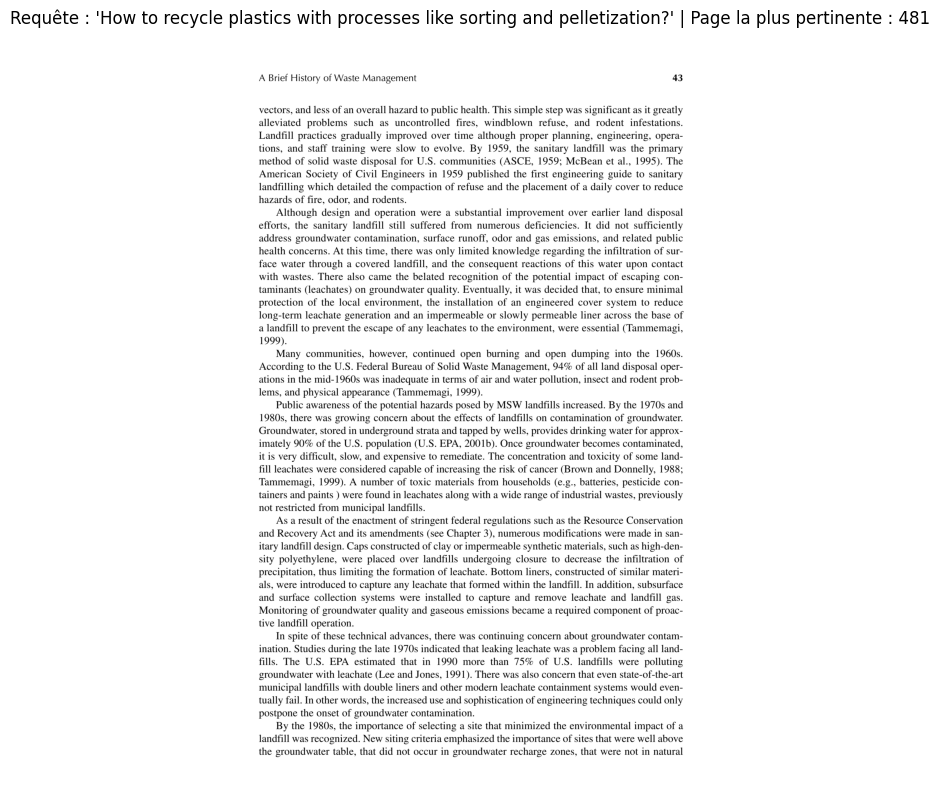

In [95]:
import fitz
import matplotlib.pyplot as plt

# Afficher la page la plus pertinente
pdf_path = "waste.pdf"
doc = fitz.open(pdf_path)
most_relevant_page_idx = top_results_dot_product.indices[0]
most_relevant_page_number = pages_and_texts[most_relevant_page_idx.item()]["page_number"] - 1
# Ajuster le décalage si nécessaire (exemple : si le livre commence à la page 100 dans waste.pdf)
décalage = 0  # À ajuster selon votre PDF
most_relevant_page_number += décalage
page = doc.load_page(most_relevant_page_number)

img = page.get_pixmap(dpi=300)
doc.close()

img_array = np.frombuffer(img.samples_mv, dtype=np.uint8).reshape((img.h, img.w, img.n))

plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Requête : '{query}' | Page la plus pertinente : {most_relevant_page_number + 1}")
plt.axis('off')
plt.show()

In [96]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)

    # Get Euclidean/L2 norm of each vector (removes the magnitude, keeps direction)
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_product / (norm_vector1 * norm_vector2)

# Example tensors
vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)

# Calculate dot product
print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))

# Calculate cosine similarity
print("Cosine similarity between vector1 and vector2:", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3:", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4:", cosine_similarity(vector1, vector4))

Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)
Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)


In [97]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Encoder la requête
    query_embedding = model.encode(query, 
                                   convert_to_tensor=True) 

    # Obtenir les scores de produit scalaire sur les embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Temps pris pour obtenir les scores sur {len(embeddings)} embeddings : {end_time-start_time:.5f} secondes.")

    scores, indices = torch.topk(input=dot_scores, 
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Prend une requête, récupère les ressources les plus pertinentes et les affiche par ordre décroissant.

    Note : Nécessite que pages_and_chunks soit formaté d'une manière spécifique (voir référence ci-dessus).
    """
    
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)
    
    print(f"Requête : {query}\n")
    print("Résultats :")
    # Parcourir les scores et indices associés
    for score, index in zip(scores, indices):
        print(f"Score : {score:.4f}")
        # Afficher le chunk de phrase pertinent (les scores étant décroissants, le plus pertinent vient en premier)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Afficher le numéro de page pour référence supplémentaire et vérification
        print(f"Numéro de page : {pages_and_chunks[index]['page_number']}")
        print("\n")



In [98]:
query = "What are the recycling solutions for glass?"

# Obtenir les scores et indices des résultats les plus pertinents
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

[INFO] Temps pris pour obtenir les scores sur 2506 embeddings : 0.00011 secondes.


(tensor([0.7644, 0.7266, 0.7243, 0.7228, 0.7155], device='cuda:0'),
 tensor([2481, 1165, 2480,  478, 1160], device='cuda:0'))

In [99]:
# Afficher les textes des meilleurs scores
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

[INFO] Temps pris pour obtenir les scores sur 2506 embeddings : 0.00010 secondes.
Requête : What are the recycling solutions for glass?

Résultats :
Score : 0.7644
CHAPTER 4 Breaking Down Recycling and Special Waste 33 These materials are ©
2020 John Wiley & Sons, Inc. Any dissemination, distribution, or unauthorized
use is strictly prohibited. Anything that doesn’t shatter and pass through the
screen is removed and recycled separately. From there, the glass particles go
through a heated air dryer that burns off any sugar or bacte- ria and loosens
any remaining glue from old labels. The clean, dry glass particles are then
screened again to sort them by size, pulling out any large particles for more
pulverizing. An optical sorter separates the glass into three colors — flint
(clear), amber (brown), and green. The result is glass cullet in a consistent
particle size, ready to be melted down to make new glass. Recycling Effectively
Many people try to recycle, but a lot of them don’t do it

### Getting an LLM for local generation

In [100]:
# Get GPU available memory
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 4 GB


In [101]:
torch.tensor([1.0]).dtype

torch.float32

In [102]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from transformers.utils import is_flash_attn_2_available 

#  Configuration de la quantization (nécessaire pour 4GB de VRAM)
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

#  Vérification de Flash Attention 2 pour optimiser l'entraînement
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
    attn_implementation = "flash_attention_2"
else:
    attn_implementation = "sdpa"
print(f"[INFO] Using attention implementation: {attn_implementation}")

# Choix du modèle (adapté à 4GB de VRAM)
model_id = "google/gemma-2b-it"
print(f"[INFO] Using model_id: {model_id}")
# Chargement du tokenizer
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

#  Chargement du modèle en 4-bit avec Flash Attention et Gradient Checkpointing
llm_model = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=model_id, 
    torch_dtype=torch.float16,  # Réduction mémoire
    quantization_config=quantization_config,
    low_cpu_mem_usage=True,  # Économise la RAM
    attn_implementation=attn_implementation
)

#  Active Gradient Checkpointing (indispensable pour 4GB)
llm_model.gradient_checkpointing_enable()  

#  Envoi sur GPU avec `torch.compile` pour améliorer l'efficacité
llm_model.to("cuda")
llm_model = torch.compile(llm_model)  # Optimisation

print("[INFO] Modèle prêt à l'entraînement ! ")

[INFO] Using attention implementation: sdpa
[INFO] Using model_id: google/gemma-2b-it


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

[INFO] Modèle prêt à l'entraînement ! 


In [103]:
pip show onnxruntime-gpu

Name: onnxruntime-gpu
Version: 1.21.0
Summary: ONNX Runtime is a runtime accelerator for Machine Learning models
Home-page: https://onnxruntime.ai
Author: Microsoft Corporation
Author-email: onnxruntime@microsoft.com
License: MIT License
Location: c:\users\fatto\appdata\local\programs\python\python310\lib\site-packages
Requires: coloredlogs, flatbuffers, numpy, packaging, protobuf, sympy
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [104]:
llm_model

OptimizedModule(
  (_orig_mod): GemmaForCausalLM(
    (model): GemmaModel(
      (embed_tokens): Embedding(256000, 2048, padding_idx=0)
      (layers): ModuleList(
        (0-17): 18 x GemmaDecoderLayer(
          (self_attn): GemmaAttention(
            (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
            (k_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
            (v_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
            (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          )
          (mlp): GemmaMLP(
            (gate_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
            (up_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
            (down_proj): Linear4bit(in_features=16384, out_features=2048, bias=False)
            (act_fn): GELUActivation()
          )
          (input_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
          (post_attenti

In [105]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

1515268096

In [106]:
def get_model_mem_size(model: torch.nn.Module):
    """
    Get how much memory a PyTorch model takes up.

    See: https://discuss.pytorch.org/t/gpu-memory-that-model-uses/56822
    """
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate various model sizes
    model_mem_bytes = mem_params + mem_buffers # in bytes
    model_mem_mb = model_mem_bytes / (1024**2) # in megabytes
    model_mem_gb = model_mem_bytes / (1024**3) # in gigabytes

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 2039632384, 'model_mem_mb': 1945.15, 'model_mem_gb': 1.9}

In [107]:
# Définir la requête adaptée au recyclage
input_text = "What are the recycling solutions for plastics?"
print(f"Texte d'entrée :\n{input_text}")

# Créer un modèle de dialogue pour un modèle ajusté aux instructions
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# Appliquer le modèle de chat
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False,  # Garder sous forme de texte brut (non tokenisé)
                                       add_generation_prompt=True)
print(f"\nPrompt (formaté) :\n{prompt}")

Texte d'entrée :
What are the recycling solutions for plastics?

Prompt (formaté) :
<bos><start_of_turn>user
What are the recycling solutions for plastics?<end_of_turn>
<start_of_turn>model



In [108]:
%%time

# Tokenize the input text (turn it into numbers) and send it to GPU
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
print(f"Model input (tokenized):\n{input_ids}\n")

# Generate outputs passed on the tokenized input
# See generate docs: https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/text_generation#transformers.GenerationConfig 
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256) # define the maximum number of new tokens to create
print(f"Model output (tokens):\n{outputs[0]}\n")

Model input (tokenized):
{'input_ids': tensor([[     2,      2,    106,   1645,    108,   1841,    708,    573,  38445,
           8319,    604,  65133, 235336,    107,    108,    106,   2516,    108]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}



C:\Users\fatto\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\integrations\sdpa_attention.py:48: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Model output (tokens):
tensor([     2,      2,    106,   1645,    108,   1841,    708,    573,  38445,
          8319,    604,  65133, 235336,    107,    108,    106,   2516,    108,
           688, 163867,  20851,    604, 121276,    688,    109,    688, 235274,
        235265,  36728,  85393,  66058,    109, 235287,   5231,  65660,  24922,
           578,  27649,  66058,  85393,   9975,  24922,    578,  27649,    603,
           573,   1546,   3818,   1736,    576,   9975,  38445, 235265,    108,
        235287,   5231,  65660,  14013,    578,  15796,  66058,  40618,    578,
         15796,   1644,    576, 104719,    591,   3328, 235275,    578, 144758,
           591,  11564, 235275,    708,   1170, 125797, 235265,    108, 235287,
          5231,  65660,  50997,    578, 126148,  66058, 180782,   9975,  50997,
           578, 126148,    798,    614,   1671,    604,   4282,   8557, 235269,
          1582,    685,  16241,    578,   6584, 235265,    109,    688, 235284,
        235265,  

In [109]:
# Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<bos><bos><start_of_turn>user
What are the recycling solutions for plastics?<end_of_turn>
<start_of_turn>model
**Recycling Solutions for Plastics**

**1. Mechanical Recycling:**

* **Plastic bottles and containers:** Recycling plastic bottles and containers is the most common form of plastic recycling.
* **Plastic films and bags:** Films and bags made of polyethylene (PE) and polypropylene (PP) are also recyclable.
* **Plastic lumber and pallets:** Recycled plastic lumber and pallets can be used for various applications, such as furniture and construction.

**2. Chemical Recycling:**

* **Plastic waste to gas (PLNG):** Certain plastics, such as polyethylene (PE) and polypropylene (PP), can be converted into fuels through chemical processes.
* **Chemical recycling:** Chemicals can be used to break down plastic into its component materials, which can then be reused.

**3. Mechanical Recycling:**

* **Plastic sorting and collection:** Public awareness campaigns and

In [110]:
print(f"Input text: {input_text}\n")
print(f"Output text:\n{outputs_decoded.replace(prompt, '').replace('<bos>', '').replace('<eos>', '')}")

Input text: What are the recycling solutions for plastics?

Output text:
**Recycling Solutions for Plastics**

**1. Mechanical Recycling:**

* **Plastic bottles and containers:** Recycling plastic bottles and containers is the most common form of plastic recycling.
* **Plastic films and bags:** Films and bags made of polyethylene (PE) and polypropylene (PP) are also recyclable.
* **Plastic lumber and pallets:** Recycled plastic lumber and pallets can be used for various applications, such as furniture and construction.

**2. Chemical Recycling:**

* **Plastic waste to gas (PLNG):** Certain plastics, such as polyethylene (PE) and polypropylene (PP), can be converted into fuels through chemical processes.
* **Chemical recycling:** Chemicals can be used to break down plastic into its component materials, which can then be reused.

**3. Mechanical Recycling:**

* **Plastic sorting and collection:** Public awareness campaigns and infrastructure improvements are essential for effective plast

In [111]:
# Questions sur le recyclage générées dans un style structuré (similaire à GPT-4)
recycling_questions = [
    "What are the main categories of waste, and how are they typically managed?",
    "How do mechanical and chemical recycling differ in their processes and outcomes?",
    "Describe the process of sorting and processing plastics for recycling.",
    "What role does composting play in managing organic waste? Name five compostable materials.",
    "Explain the concept of a circular economy and its importance in waste management."
]

# Liste de questions sur le recyclage créées manuellement
manual_recycling_questions = [
    "How often should households sort their recyclable waste?",
    "What are the challenges in recycling electronic waste?",
    "How does shredding help in the recycling of plastics?",
    "What is the recommended recycling rate for municipal solid waste?",
    "What are biodegradable plastics?"
]

# Fusionner les deux listes de questions
query_list = recycling_questions + manual_recycling_questions

In [112]:
import random
query = random.choice(query_list)

print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

Query: Explain the concept of a circular economy and its importance in waste management.
[INFO] Temps pris pour obtenir les scores sur 2506 embeddings : 0.00009 secondes.


(tensor([0.8188, 0.8011, 0.7807, 0.7729, 0.7540], device='cuda:0'),
 tensor([680, 592,  16,  15, 593], device='cuda:0'))

### Augmenting our prompt with context items

In [113]:
def prompt_formatter(query: str, 
                     context_items: list[dict]) -> str:
    """
    Augments query with text-based context from context_items.
    """
    # Join context items into one dotted paragraph
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    # Create a base prompt with examples to help the model
    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What are the main categories of waste?
Answer: The main categories of waste include organic waste, plastics, metals, glass, and hazardous waste. Organic waste, such as food scraps, can be composted to produce fertilizer. Plastics are often sorted, shredded, and melted for recycling into new products. Metals, like aluminum and steel, are melted down and reused in industry. Glass is infinitely recyclable by melting and reshaping it. Hazardous waste, such as batteries, requires special treatment to prevent environmental contamination.
\nExample 2:
Query: What are the benefits of composting organic waste?
Answer: Composting organic waste offers several benefits. It reduces the amount of waste sent to landfills, thereby decreasing methane emissions, a potent greenhouse gas. Compost enhances soil fertility by adding essential nutrients, promoting plant growth. It also helps retain soil moisture, reducing the need for watering. Additionally, composting can be done on a small scale, such as in home gardens, encouraging community participation in sustainable waste management.
\nExample 3:
Query: Why is sorting plastics important in recycling?
Answer: Sorting plastics is crucial in recycling because it separates different types of plastics, such as PET, HDPE, and PP, which have distinct chemical properties. Effective sorting ensures that plastics can be properly processed in subsequent steps, like shredding and pelletization. Without sorting, mixed plastics can contaminate the recycling process, reducing the quality of recycled materials. Moreover, proper sorting lowers processing costs and increases recycling efficiency, contributing to a circular economy.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""

    # Update base prompt with context items and query   
    base_prompt = base_prompt.format(context=context, query=query)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
         "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)
    return prompt

In [114]:
query = random.choice(query_list)
print(f"Query: {query}")

# Get relevant resources
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
    
# Create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format prompt with context items
prompt = prompt_formatter(query=query,
                          context_items=context_items)
print(prompt)

Query: What is the recommended recycling rate for municipal solid waste?
[INFO] Temps pris pour obtenir les scores sur 2506 embeddings : 0.00008 secondes.
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What are the main categories of waste?
Answer: The main categories of waste include organic waste, plastics, metals, glass, and hazardous waste. Organic waste, such as food scraps, can be composted to produce fertilizer. Plastics are often sorted, shredded, and melted for recycling into new products. Metals, like aluminum and steel, are melted down and reused in industry. Glass is infinitely recyclable by melting and reshaping it. Hazardous waste, such as

In [115]:
%%time

# Tokenize the prompt and move to GPU
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate an output of tokens
outputs = llm_model.generate(**input_ids,
                             temperature=0.7, # Lower temperature = more deterministic outputs, higher temperature = more creative outputs
                             do_sample=True, # Whether to use sampling, see https://huyenchip.com/2024/01/16/sampling.html for more
                             max_new_tokens=256) # Number of new tokens to generate from the prompt

# Convert the output tokens into text
output_text = tokenizer.decode(outputs[0])

# Display the query and the generated answer (removing the prompt from the output)
print(f"Query: {query}")
print(f"RAG answer:\n{output_text.replace(prompt, '')}")

Query: What is the recommended recycling rate for municipal solid waste?
RAG answer:
<bos>The passage does not specify the recommended recycling rate for municipal solid waste, so I cannot answer this question from the provided context.<eos>
CPU times: total: 14.6 s
Wall time: 14.9 s


In [116]:
def ask(query: str, 
        temperature: float = 0.7,
        max_new_tokens: int = 256,  # Reduced for 4 GB GPU
        format_answer_text: bool = True, 
        return_answer_only: bool = True):
    """
    Takes a query about recycling or waste management, finds relevant resources/context from waste.pdf,
    and generates an answer using the TinyLlama-1.1B-Chat-v1.0 model.
    
    Args:
        query (str): The user's query (e.g., "What are the recycling solutions for plastics?").
        temperature (float): Controls randomness in generation (lower = more deterministic).
        max_new_tokens (int): Maximum number of new tokens to generate.
        format_answer_text (bool): If True, cleans up the output text by removing special tokens.
        return_answer_only (bool): If True, returns only the answer; otherwise, returns answer and context.
    
    Returns:
        str or tuple: The generated answer, or (answer, context_items) if return_answer_only is False.
    """
    
    # Retrieve the scores and indices of the top related results from waste.pdf
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)
    
    # Create a list of context items from the retrieved results
    context_items = [pages_and_chunks[i] for i in indices]

    # Add the relevance score to each context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu()  # Move score back to CPU for compatibility
        
    # Format the prompt with the query and context items
    prompt = prompt_formatter(query=query,
                              context_items=context_items)
    
    # Tokenize the prompt and move to GPU
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens using TinyLlama
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)
    
    # Convert the output tokens into text
    output_text = tokenizer.decode(outputs[0])

    # Clean up the output text if requested
    if format_answer_text:
        # Remove the prompt, special tokens, and any unnecessary messages
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")

    # Return only the answer if requested, otherwise return answer and context
    if return_answer_only:
        return output_text
    
    return output_text, context_items

In [117]:
import random

# Select a random query from the recycling-focused query_list
query = random.choice(query_list)
print(f"Query: {query}")

# Answer the query with context and return both the answer and context items
answer, context_items = ask(query=query, 
                            temperature=0.7,
                            max_new_tokens=256,  # Reduced for 4 GB GPU
                            return_answer_only=False)

# Display the generated answer and context items
print(f"\nAnswer:\n")
print_wrapped(answer)
print(f"\nContext items used:")
for item in context_items:
    print(f"- Score: {item['score']:.4f}, Page: {item['page_number']}, Text: {item['sentence_chunk']}")

Query: What role does composting play in managing organic waste? Name five compostable materials.
[INFO] Temps pris pour obtenir les scores sur 2506 embeddings : 0.00009 secondes.

Answer:

Sure, here's the answer to the user's query:  Composting plays a crucial role in
managing organic waste by transforming it into a valuable resource. It offers
several benefits, including reducing the amount of waste sent to landfills,
enhancing soil fertility, and providing essential nutrients to plants.
Composting also offers a means for safe disposal and resource recovery.  Five
compostable materials include:  - Organic materials such as yard waste, food
scraps, and other organic wastes. - Agricultural wastes (plant residues, animal
manures). - Food factory waste. - Municipal wastewaster treatment solids
(“biosolids”). - Mixed waste compost at centralized processing facilities.

Context items used:
- Score: 0.7010, Page: 673, Text: The finished organic product has several potential appli- cations.

In [118]:
import random

# Select a random query from the recycling-focused query_list
query = random.choice(query_list)
print(f"Query: {query}")

# Answer the query with context and return both the answer and context items
answer, context_items = ask(query=query, 
                            temperature=0.7,
                            max_new_tokens=256,  # Reduced for 4 GB GPU
                            return_answer_only=False)

# Display the generated answer and context items
print(f"\nAnswer:\n")
print_wrapped(answer)
print(f"\nContext items used:")
for item in context_items:
    print(f"- Score: {item['score']:.4f}, Page: {item['page_number']}, Text: {item['sentence_chunk']}")

Query: What role does composting play in managing organic waste? Name five compostable materials.
[INFO] Temps pris pour obtenir les scores sur 2506 embeddings : 0.00009 secondes.

Answer:

Sure, here are the relevant passages from the context that answer your query:
**Passage 1:** > Composting serves as a soil conditioner (i.e., an organic
matter source which improves water-holding capacity, increases aeration, and
improves drainage), and it supplies nutrients, particularly N, P, and S, all of
which occur primarily in the organic form in soils.  **Passage 2:** > Many such
trace nutrients including Cu, Fe, Zn, and Ni. Compost is also used in landfill
operations as a daily cover material, for landscaping applications, and for
remediation of contaminated sites and mined lands (U. S. EPA,1997, 1998).
**Passage 3:** >The organic fraction of MSW can circumvent land disposal and
undergo other fates including direct conversion into fuels, fermentation as a
biofuel, pyrolysis, and composting. 

We begin with standard RAG: 

Data collection (Document PDF dedicated for waste management) 

Import documents 

Get some stats on the data 

Process text for embedding 

Split pages into sentences with spaCy 

Chunking our sentences 

Splitting each chunk into its own item 

Embed text chunks with embedding model 

We used the sentence-transformers 

Specifically we used all-minilm-v2 

Stored 2506 embeddings in file CSV 

RAG and Search 

0.00176s time take to get the embeddings 

Increase the embeddings *100 

Test the model 

The first query result is 0.7305 ! Good result 

Generate an LLM, We used Gemma 2b cause of lack of GPU. (Hugging face) 

Generating text with our LLM 

Augmenting our prompt with context 

Test our RAG pipeline 

Deploy with Gradio 

After many test on our chatbot we notice : 

Fast response (0.6s - 0.10) : 😊  

Exact Match : 🙁  

Performance (answer quality, completed): 😢   

Embedding-based similarity between answer and reference: 🙁  

So, we have enhance our Rag with : 

Evaluate the preprocessing 

 We have try with the model of embedding all-mpnet-v2  

We have generated other ollama locally , we used llava 7b (Augmenting the parametres) 

We have change our file store from CSV to FAISS for semantic search. 

Test our RAG pipeline 

Deploy with Streamlit 

 

After the enhancement : 

Exact Match : 😊  

Performance : 😊  

Embedding-based similarity between answer and reference : 😊  

Rapidity (1.5m - 2m): 🙁  

 

Good, Now we can implement a agentic RAG 

 

Add two agents retrieval for dynamic document filtering and task planner for multi-hop query decomposition(sub-task). 

Add one API's google books and wikipedia source for help llm 

Enhance the Prompt engeneering with waste key. 

Change model llm phi3: mini (3.8b para) for more rapidity 